<img src="../img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.1 January 2020  
Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

# <a id='processitems'></a>processitems table
The *processitems* table contains all catheters, drains, tubes, and continous non-medication processes (e.g. renal replacement therapy, hypothermia induction, etc) that patients received during their stay on the ICU. All items have an associated admissionid from the [admissions](admissions.ipynb#admissions) table.

## Fields
|Name|Type|Description|
|----|----|-----------|
|admissionid|integer|links the item with the admissionid in the [admissions](admissions.ipynb#admissions) table.|
|itemid|integer|id to identify the type of process.|
|[item](#item)|string|name of the process.|
|start|integer|start time (time of introduction) of the process, in milliseconds since the first ICU admission.| 
|stop|integer|stop time (time of removal) of the process, in milliseconds since the first ICU admission.| 
|[duration](#duration)|integer|duration of the process, i.e. the difference between start and stop times, in minutes.|

# Example Python and SQL scripts

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

# Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Overview of all fields

In [4]:
sql = """
SELECT * FROM processitems;
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT * FROM processitems;

```

,admissionid,itemid,item,start,stop,duration
0,0,9159,Arterielijn Radialis,20520000,148800000,2138
1,0,9166,Trilumen Jugularis,20520000,148800000,2138
2,0,9174,Swan Ganz Jugularis,20520000,139020000,1975
3,0,9328,Beademen,20520000,69120000,810
4,0,9399,Wonddrain 1,20520000,94320000,1230
5,0,9400,Wonddrain 2,20520000,142080000,2026
6,0,9403,Thoraxdrain 1,20520000,148800000,2138
7,0,9415,Urine-Catheter (CAD),20520000,148800000,2138
8,0,9417,Sonde,20520000,148800000,2138
9,0,9422,Perifeer infuus,20520000,148800000,2138


In [5]:
df.describe()

,admissionid,itemid,start,stop,duration
count,257740.000000,257740.000000,2.577400e+05,2.577400e+05,2.577400e+05
mean,11767.607151,9960.565710,4.082503e+09,4.359336e+09,2.074316e+03
std,6757.890264,1582.222832,2.383548e+10,2.385054e+10,3.723910e+05
min,0.000000,7926.000000,-3.426000e+08,-5.670000e+07,-5.455790e+07
25%,5970.000000,9328.000000,2.760000e+06,7.374000e+07,9.240000e+02
50%,11755.000000,9415.000000,9.480000e+06,1.716600e+08,1.389000e+03
75%,17608.000000,9422.000000,3.608400e+08,9.540000e+08,4.533000e+03
max,23552.000000,21188.000000,3.916624e+11,3.916687e+11,3.011310e+05


## <a id='item'></a>item

In [6]:
sql = """
SELECT item, COUNT(item) AS "number of times", itemid
FROM processitems
GROUP BY item, itemid
ORDER BY "number of times" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT item, COUNT(item) AS "number of times", itemid
FROM processitems
GROUP BY item, itemid
ORDER BY "number of times" DESC

```

,item,number of times,itemid
0,Perifeer infuus,39566,9422
1,Sonde,24185,9417
2,Arterielijn Radialis,22548,9159
3,Urine-Catheter (CAD),21390,9415
4,Beademen,18518,9328
5,Tube,15057,12634
6,Trilumen Jugularis,10600,9166
7,Thoraxdrain 1,9959,9403
8,Swan Ganz Jugularis,6677,9174
9,Wonddrain 1,5833,9399


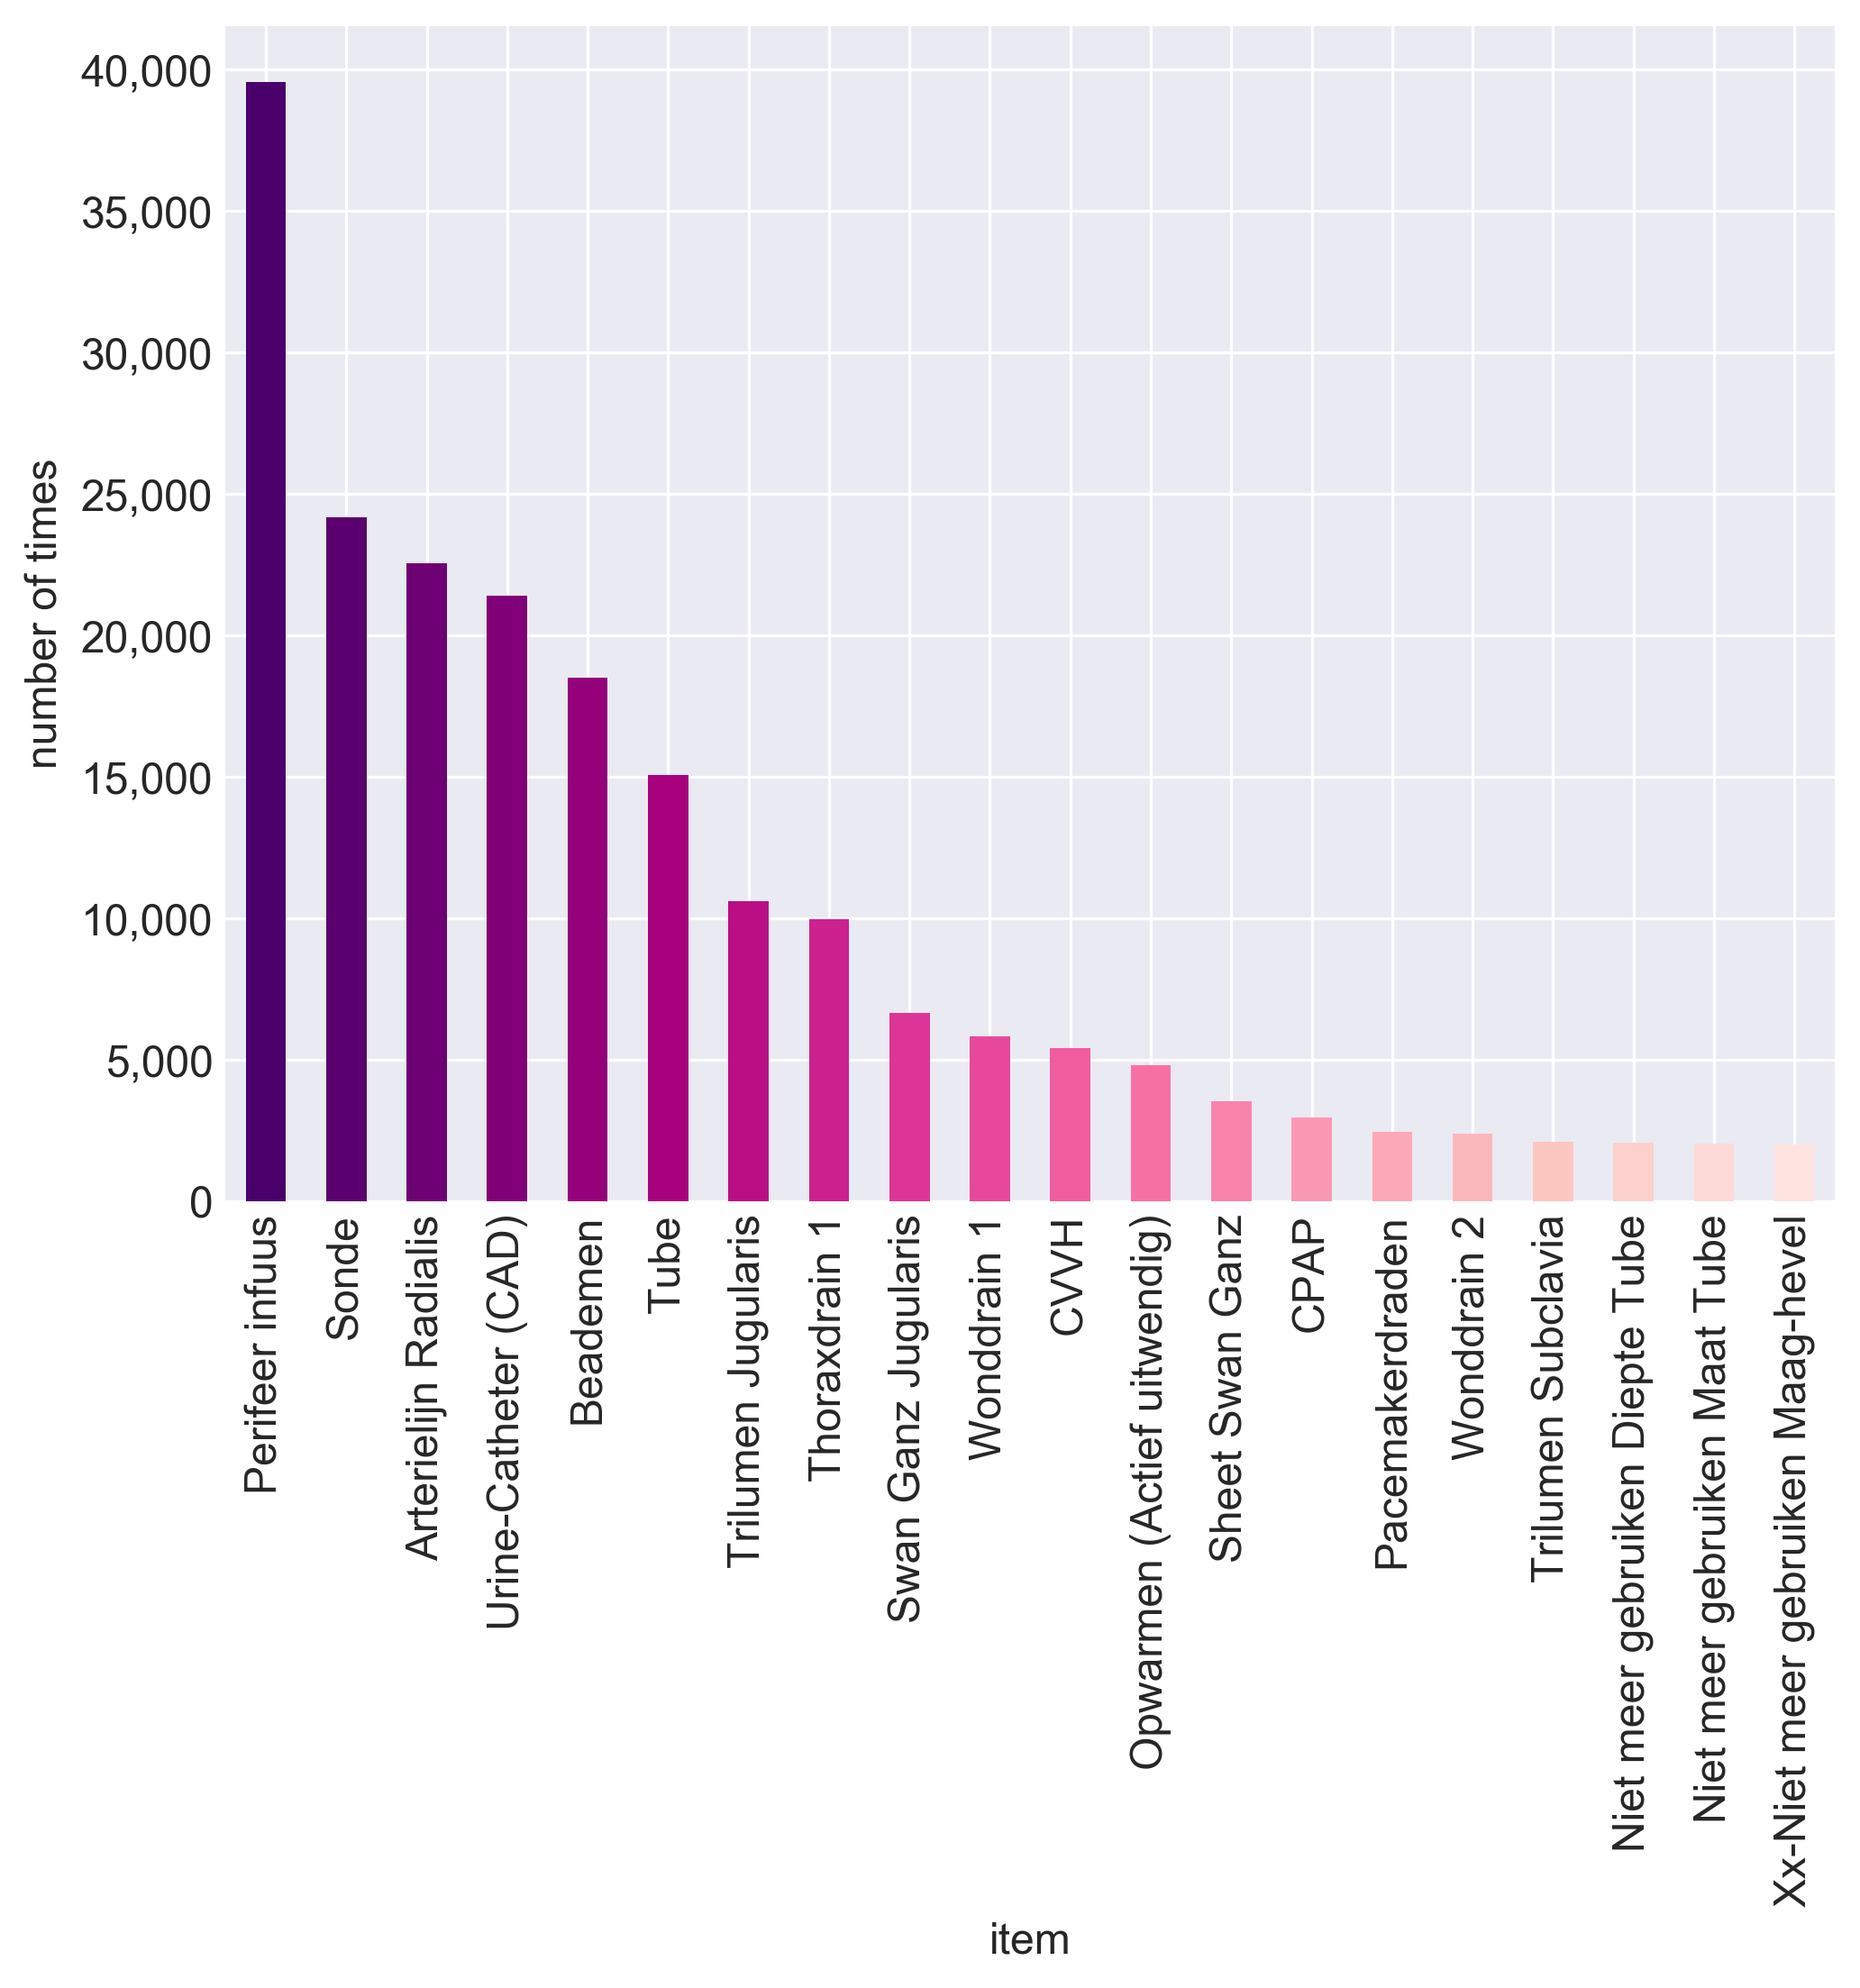

In [7]:
selection = df.head(20)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(selection.index))
ax = selection.plot.bar(x=selection.columns[0],y=selection.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=selection.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='duration'></a>duration

In [8]:
sql = """
SELECT *
FROM processitems
WHERE duration < 0 --stop time 'undefined'
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(5)

``` mysql

SELECT *
FROM processitems
WHERE duration < 0 --stop time 'undefined'

```

,admissionid,itemid,item,start,stop,duration
0,1677,9159,Arterielijn Radialis,732480000,-1899,-54557903
1,1677,9161,Dialyselijn Femoralis,732600000,-1899,-54557905
2,9810,9169,Quad lumen Subclavia,717360000,-1899,-54557892
3,9810,9188,X-Proces Lijnen/Catheter/Drain,717300000,-1899,-54557891
4,9810,9328,Beademen,717300000,-1899,-54557891


``` mysql

SELECT *
FROM processitems
WHERE itemid IN (
    9170, --Quad lumen Jugularis
    9166, --Trilumen Jugularis
    12400, --Duo lumen Jugularis
    9162, --Dialyselijn Jugularis
    9595, --Enkel lumen Jugularis
    13422, --Trauma catheter Jugularis
    9168, --Quad lumen Femoralis
    9165, --Trilumen Femoralis
    9161, --Dialyselijn Femoralis
    13421, --Trauma catheter Femoralis
    12399, --Duo lumen Femoralis
    9594, --Enkel lumen Femoralis
    9169, --Quad lumen Subclavia
    9167, --Trilumen Subclavia
    9596, --Enkel lumen Subclavia
    9163, --Dialyselijn Subclavia
    13423 --Trauma catheter Subclavia
);

```

Text(0, 0.5, 'number of central venous catheters')

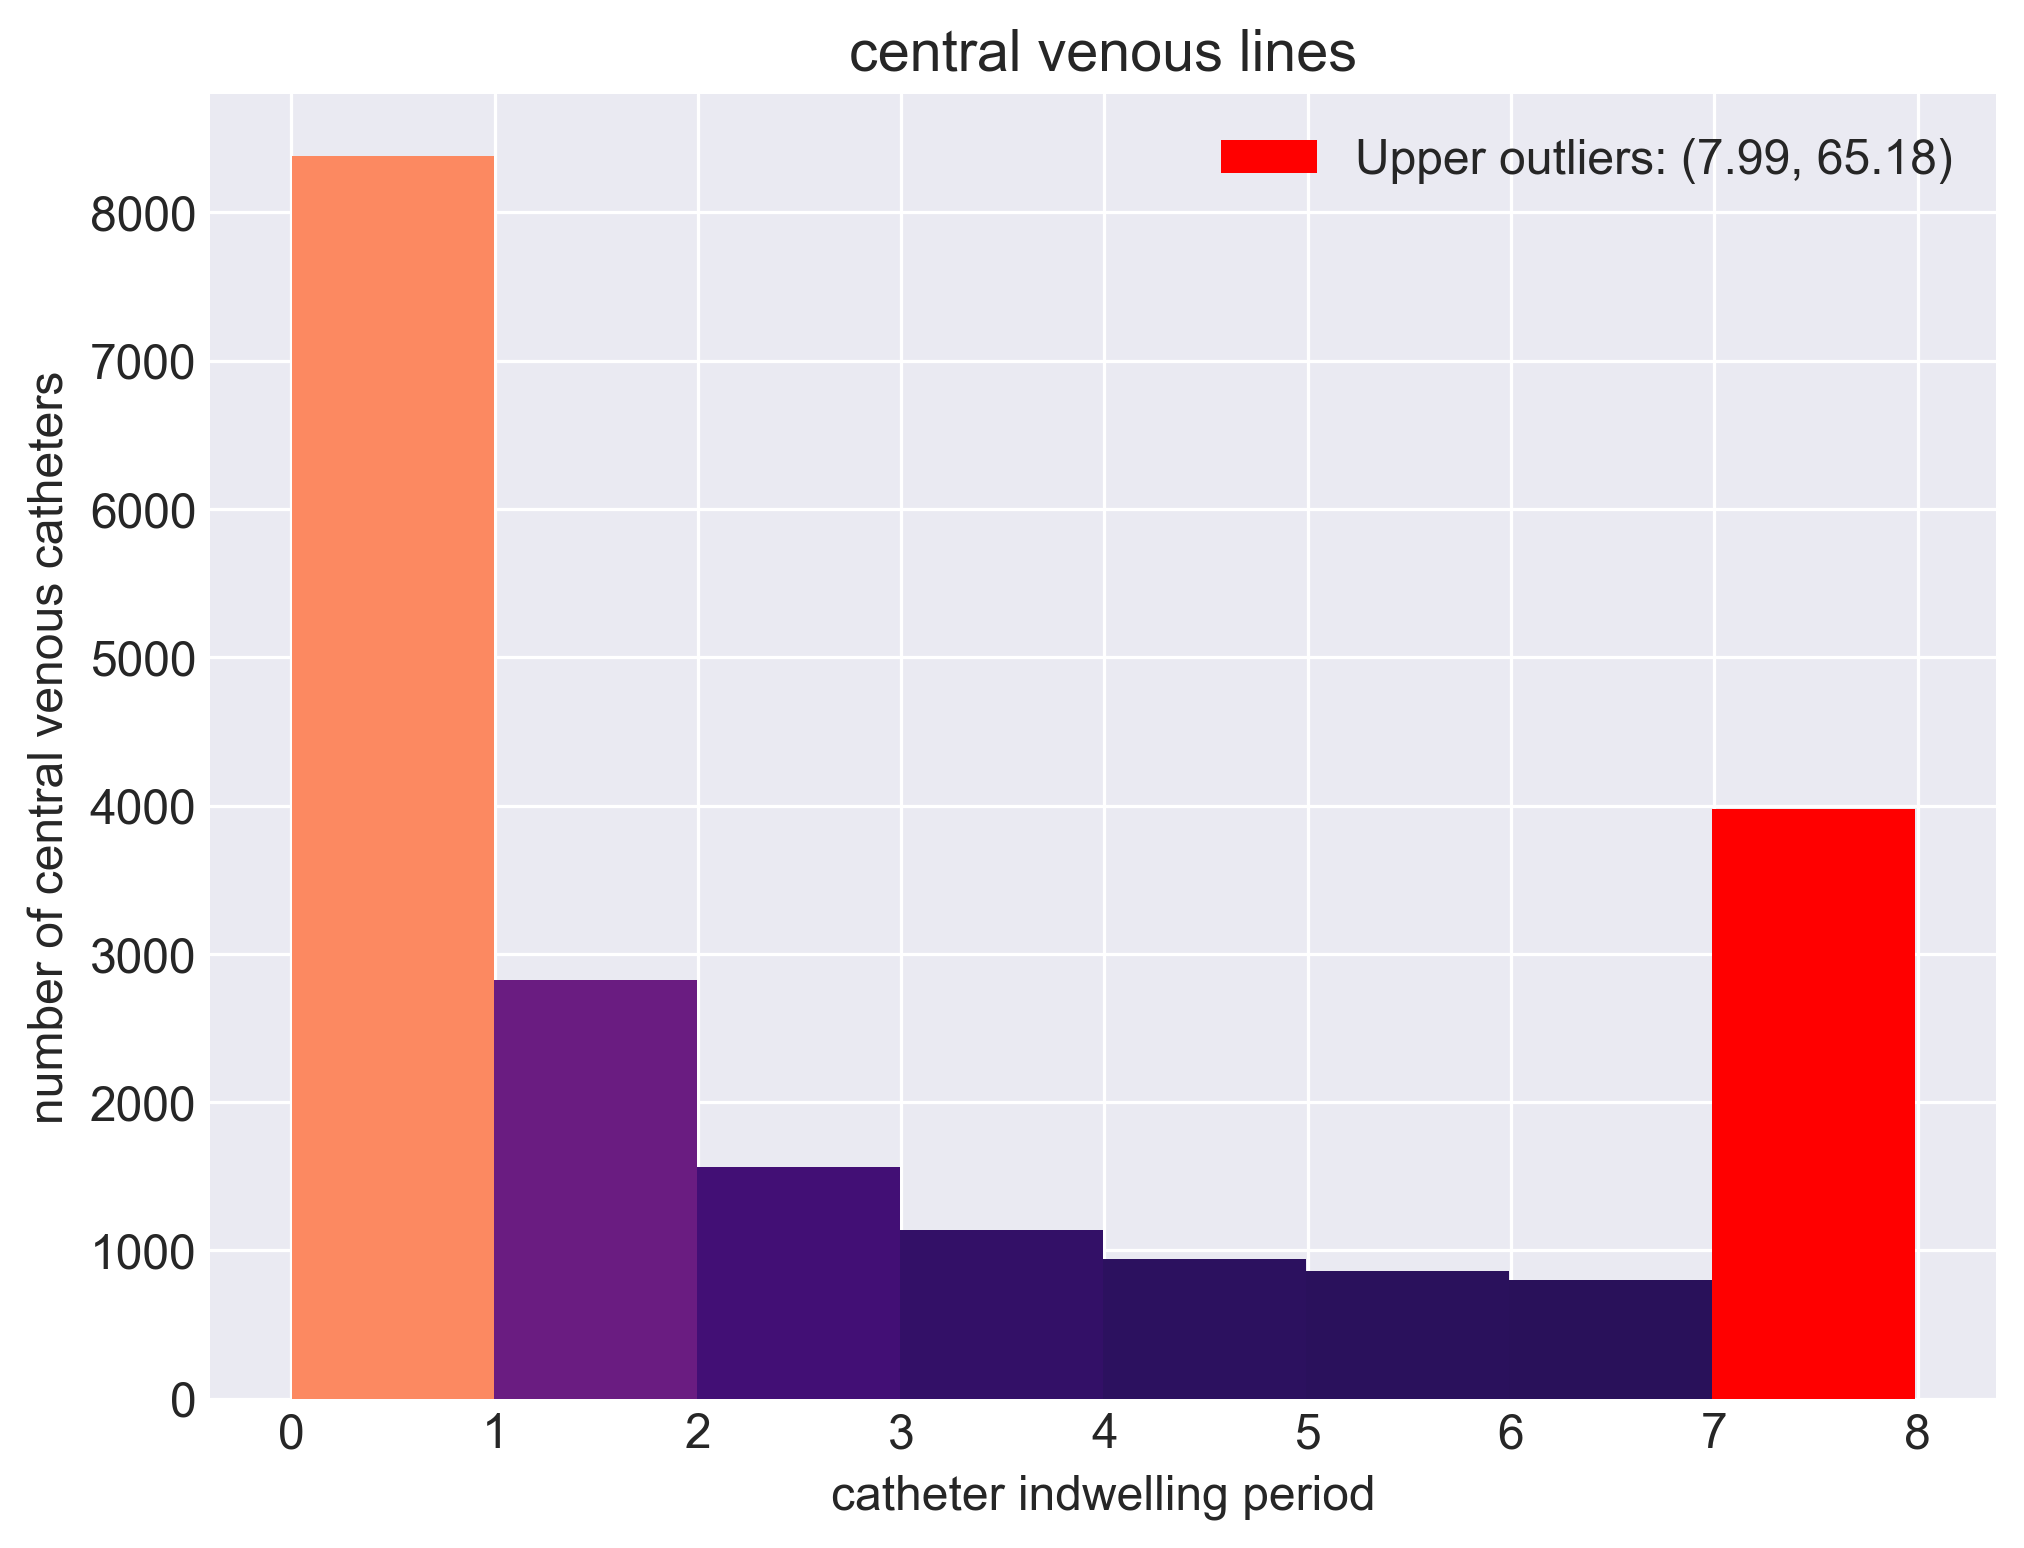

In [9]:
#duration of central venous lines
sql = """
SELECT *
FROM processitems
WHERE itemid IN (
    9170, --Quad lumen Jugularis
    9166, --Trilumen Jugularis
    12400, --Duo lumen Jugularis
    9162, --Dialyselijn Jugularis
    9595, --Enkel lumen Jugularis
    13422, --Trauma catheter Jugularis
    9168, --Quad lumen Femoralis
    9165, --Trilumen Femoralis
    9161, --Dialyselijn Femoralis
    13421, --Trauma catheter Femoralis
    12399, --Duo lumen Femoralis
    9594, --Enkel lumen Femoralis
    9169, --Quad lumen Subclavia
    9167, --Trilumen Subclavia
    9596, --Enkel lumen Subclavia
    9163, --Dialyselijn Subclavia
    13423 --Trauma catheter Subclavia
);
"""

display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(20)

#plot the data
data = df[df['duration'] > 0]['duration']/(24*60)
fig = amsterdamumcdb.outliers_histogram(data, bins=8)
fig.title('central venous lines')
fig.xlabel('catheter indwelling period')
fig.ylabel('number of central venous catheters')